### This is the final part, where we compare the likelihoods between track-fitter and cascade-fitter

In [3]:
from I3Tray import *
from icecube import icetray, dataclasses, phys_services, sim_services, dataio,  earthmodel_service, neutrino_generator, tableio, hdfwriter
from icecube.simprod import segments
from icecube.icetray import I3Units, I3Frame
from icecube.dataclasses import I3Particle
from icecube.simclasses import I3MMCTrack
from icecube.icetray import I3Units, OMKey, I3Frame
import numpy as np
from matplotlib import pyplot as plt
from Reconstruction.llh.reco_pdfs import cpandel as pdf
import numpy as np
import sys, os
import math
from os import path
from scipy import stats
from scipy.stats import norm
import random as rand
import scipy.special as sp
from scipy import optimize as op
import time

In [4]:
def frame_absent(run_num):
    if (run_num==6 or run_num==14 or run_num==36 or run_num==41 or run_num==49 or run_num==54 or run_num==59 or run_num==61 or run_num==76 or run_num==80 or run_num==82 or run_num==106 or run_num==131 or run_num==133 
        or run_num==129 or run_num==140 or run_num==149 or run_num==155 or run_num==172 or run_num==176 or run_num==147 or run_num==189 or run_num==193 or run_num==198 or run_num==208 or run_num==214 or run_num==216
        or run_num==223 or run_num==235 or run_num==238 or run_num==252 or run_num==284 or run_num==288 or run_num==311 or run_num==369 or run_num==371 or run_num==377 or run_num==379 or run_num==378 or run_num==385 or run_num==389 or run_num==390 
        or run_num==391 or run_num==392 or run_num==393 or run_num==397 or run_num==594
        or run_num==395 or run_num==399 or run_num==401 or run_num==403 or run_num==419 or run_num==471 or run_num==521 or run_num==522 or run_num==550 or run_num==538 or run_num==574 or 
        run_num==584 or run_num==569 or run_num==643 or run_num==646 or run_num==647 or run_num==648 
        or run_num==650 or run_num==656 or run_num==657
        or run_num==658 or run_num==659 or run_num==665 or run_num==675 or run_num==683 or run_num==685 or run_num==686 or run_num==708 or run_num==711
        or run_num==714 or run_num==726 or run_num==737 or run_num==835 or run_num==873 or run_num==889 or run_num==746 or run_num==837 or run_num==867 or run_num==878 or run_num==917 or run_num==944 or run_num==949 or run_num==954 or run_num==963 or run_num==971
        or run_num==972 or run_num==895 or run_num==984 or run_num==987 or run_num==988 or run_num==989):
        return True
    else:
        return False

In [5]:
def GetGeoTime(position,vert) :
    c = 0.299792458                                 # speed of light 
    n = 1.34
    ngroup = 1.35557                                # 1.33 is the refractive index of water at 20 degrees C
    c_n = c/ngroup                                     # light in water
    x = position.x - vert.x
    y = position.y - vert.y
    z = position.z - vert.z
    dc = np.sqrt(x*x + y*y + z*z)
    t = dc/c_n
    return dc,t

In [6]:
def anisotropy(position,vert,direction):
    alpha=0.4
    sigma=3.0
    th=0.60
    amp=1461.2

    k=(sigma*alpha/th)**2
    x1=-(vert.x-position.x)
    y1=-(vert.y-position.y)
    z1=-(vert.z-position.z)
    r1= math.sqrt(x1*x1+y1*y1+z1*z1)

    x2= direction.x
    y2= direction.y
    z2= direction.z         
    zeta=np.arccos((x1*x2+y1*y2+z1*z2)/r1)
    #weight= (amp*np.exp(k*np.cos(zeta*np.pi/180 - th))*(np.sin(zeta*np.pi/180)))/(2*np.pi*sp.iv(0,k)+(2*np.sinh(k))/k)
    
    weight= (amp*np.exp(k*np.cos(zeta*np.pi/180 - th))*(np.sin(zeta*np.pi/180)))/(np.sinh(k)/k)

    return weight

In [7]:
def GetVertexTime(pulse_series,geo_doms):
    
    c = 0.299792458                                 # speed of light
    n = 1.34
    ngroup = 1.35557                                # 1.33 is the refractive index of water at 20 degrees C
    c_n= c/ngroup                                     # light in water
    ismc = False
    if(type(pulse_series) == 'icecube.dataclasses.I3RecoPulseSeriesMap') :
        ismc = True

    totalcharge = 0.0
    vx = 0.0
    vy = 0.0
    vz = 0.0

    for domkey in pulse_series.keys() :
        domkey_nopmt =  OMKey(domkey.string, domkey.om, 0)
        for pulse in pulse_series[domkey] :
            totalcharge += pulse.charge     
            vx += geo_doms[domkey_nopmt].position.x*pulse.charge
            vy += geo_doms[domkey_nopmt].position.y*pulse.charge
            vz += geo_doms[domkey_nopmt].position.z*pulse.charge

    vertex = dataclasses.I3Position(vx/totalcharge,vy/totalcharge,vz/totalcharge)
    
    #print("GetVertexTime:",vertex)

    T0 = 0.0

    for domkey in pulse_series.keys() :
        domkey_nopmt =  OMKey(domkey.string, domkey.om, 0)
        for pulse in pulse_series[domkey] :
            dx = vertex.x - geo_doms[domkey_nopmt].position.x
            dy = vertex.y - geo_doms[domkey_nopmt].position.y
            dz = vertex.z - geo_doms[domkey_nopmt].position.z
            dist = np.sqrt(dx*dx+dy*dy+dz*dz)
            T0 += pulse.time - dist/c_n

    T0 /= totalcharge
    T0 -= 5.0
    return T0, vertex

In [8]:
def LikelihoodFunctor(data,domsUsed):
    
    pulse_series = data
    geo_doms = domsUsed
    c = 0.299792458                                 # speed of light
    n = 1.34
    ngroup = 1.35557                                # 1.33 is the refractive index of water at 20 degrees C
    c_n = c/ngroup                                     # light in water
    lambda_s = 120.                                 # scattering length of light for violet light
    lambda_a = 15.                                  # absorption length of light for violet light
    tau = 18.949132224466762                        # time parameter that has to be fit using simulations or data

    
    # uses the prior defined functions to build a likelihood function that when given a track (linefit) will produce a negative loglikelihood value
    def likelihoodFunction(vert_x, vert_y, vert_z, theta, phi, t0):
        
        dark = 1.e-15
        vertex = dataclasses.I3Position(vert_x, vert_y, vert_z)
        direction = dataclasses.I3Direction(np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta))  
    
        sum_nloglike = 0.0
        for dom in pulse_series.keys() :
            domkey =  OMKey(dom.string, dom.om, 0)
            dc,t = GetGeoTime(geo_doms[domkey].position,vertex)
            p_charge = np.exp(-dc/tau)/max(dc,0.25)
            
            for pulse in pulse_series[dom] :
                charge = 1.0
                cpandel_out = pdf(pulse.time - t0 - t ,dc)
                if(type(pulse_series) == 'icecube.dataclasses.I3RecoPulseSeriesMap') :
                    charge = pulse.charge                
                
                sum_nloglike -= charge*np.log(cpandel_out*p_charge+dark)#*anisotropy(geo_doms[domkey].position,vertex,direction)+dark)
                sum_nloglike -= charge*min(0.0,pulse.time - t0 - t)
                
        return sum_nloglike
    
    return likelihoodFunction

In [18]:
gcd = dataio.I3File('/home/users/kaustav/pone_offline/GCD/PONE_Phase1.i3.gz') #GCD file for the position of DOMs
frame_geodoms=gcd.pop_frame()
domsUsed=frame_geodoms['I3Geometry'].omgeo
nfitparameters_nutau=4
nfitparameters_llhfit=5
#count=0
nloglike_cascade_nue=[]
nloglike_cascade_nutau=[]
nloglike_track_numu=[]

for i in range(0,1000):
    print("File",i)
    if path.exists("/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst")==True:
        infile_name="/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst"
        if(frame_absent(i)==False):
            infile=dataio.I3File(infile_name)
            infile.pop_frame()
            infile.pop_frame()
            count=0
            for frame in infile:
                pulses=0
                pulseseriesmap=frame['I3Photons_PMTResponse']
                for omkey in pulseseriesmap.keys():
                     for pulse in pulseseriesmap[omkey]:
                        pulses=pulses+1
  
                data = frame['I3Photons_PMTResponse']
                linefit=frame['linefit']
                llhfit=frame['llhfit']
                direction = dataclasses.I3Direction(llhfit.dir.x,llhfit.dir.y,llhfit.dir.z)
                qFunctor = LikelihoodFunctor(data,domsUsed)
                T0, vertex = GetVertexTime(data,domsUsed)
                x=vertex.x
                y=vertex.y
                z=vertex.z
                    
                def func(x):
                    vert_x, vert_y, vert_z, theta, phi, t0 = x
                    return qFunctor(vert_x, vert_y, vert_z, theta, phi, t0)
                solution = op.minimize(fun=func, x0=np.array([x,y,z,direction.theta,direction.phi,T0]), 
                                             bounds=((-250, -250, -550, 0, 0), (250, 250, 550, np.pi, 2*np.pi)), method='Nelder-Mead')
                        
                vx=solution.x[0]
                vy=solution.x[1]
                vz=solution.x[2]
                q = dataclasses.I3Position(vx,vy,vz)
                phi = solution.x[4]
                theta = solution.x[3]
                MMCTrackList=frame['MMCTrackList']
                secondary=MMCTrackList[0].GetI3Particle()
                u = dataclasses.I3Direction(np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta))
                        
                if(frame['NuGPrimary'].pdg_encoding==16 or frame['NuGPrimary'].pdg_encoding==-16):
                    nloglike_cascade_nutau.append((solution.fun)/(pulses-nfitparameters_nutau))                
                elif(frame['NuGPrimary'].pdg_encoding==12 or frame['NuGPrimary'].pdg_encoding==-12):
                    nloglike_cascade_nue.append((solution.fun)/(pulses-nfitparameters_nutau))
                elif(frame['NuGPrimary'].pdg_encoding==14 or frame['NuGPrimary'].pdg_encoding==-14):              
                    nloglike_track_numu.append((frame['llhfit_nloglike'].value)/(pulses-nfitparameters_llhfit))

File 0


/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/Ubuntu_20.04_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in arccos
  app.launch_new_instance()


File 1
File 2
File 3
File 4
File 5
File 6
File 7
File 8
File 9
File 10
File 11
File 12
File 13
File 14
File 15
File 16
File 17
File 18
File 19
File 20
File 21
File 22
File 23
File 24
File 25
File 26
File 27
File 28
File 29
File 30
File 31
File 32
File 33
File 34
File 35
File 36
File 37
File 38
File 39
File 40
File 41
File 42
File 43
File 44
File 45
File 46
File 47
File 48
File 49
File 50
File 51
File 52
File 53
File 54
File 55
File 56
File 57
File 58
File 59
File 60
File 61
File 62
File 63
File 64
File 65
File 66
File 67
File 68
File 69
File 70
File 71
File 72
File 73
File 74
File 75
File 76
File 77
File 78
File 79
File 80
File 81
File 82
File 83
File 84
File 85
File 86
File 87
File 88
File 89
File 90
File 91
File 92
File 93
File 94
File 95
File 96
File 97
File 98
File 99
File 100
File 101
File 102
File 103
File 104
File 105
File 106
File 107
File 108
File 109
File 110
File 111
File 112
File 113
File 114
File 115
File 116
File 117
File 118
File 119
File 120
File 121
File 122
File 123
F

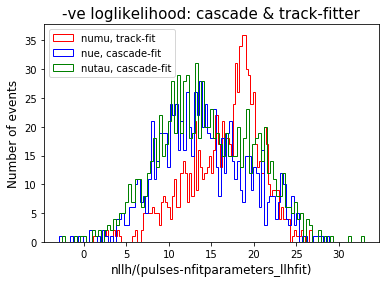

In [76]:
plt.hist(nloglike_track_numu, bins=100, histtype='step',label='numu, track-fit',color='red')
plt.hist(nloglike_cascade_nue, bins=100, histtype='step',label='nue, cascade-fit',color='blue')
plt.hist(nloglike_cascade_nutau, bins=100, histtype='step',label='nutau, cascade-fit',color='green')

plt.xlabel('nllh/(pulses-nfitparameters_llhfit)',fontsize=12)
plt.ylabel('Number of events',fontsize=12)
plt.title("-ve loglikelihood: cascade & track-fitter",fontsize=15)
plt.legend(loc='upper left')
plt.show()

In [21]:
print("nloglike_cascade_nue:",nloglike_cascade_nue)
print("-----------------------------------------------------------------")
print("nloglike_cascade_nutau",nloglike_track_nutau)
print("-----------------------------------------------------------------")
print("nloglike_track_numu",nloglike_track_numu)

nloglike_cascade_nue: [9.216613169782255, 17.95867370391688, 23.351514261404265, 13.293651151975551, 18.59422949932418, 6.592114138441377, 12.38878216853312, 20.390864933510816, 24.512849431794578, 11.709432325296936, 24.454383322256, 11.407831610394817, 15.254752861101474, 28.795151326390048, 15.24906448418767, 15.294177005770035, 19.661574290188383, 8.993689640007268, 19.910783766937175, 20.188415414269244, 9.25206323984322, 13.255710327977235, 9.620389614840322, 17.013525243146145, 10.195354355499884, 13.050833869189873, 7.335284685217539, 10.253214424674624, 17.234779497284816, 14.46694867859515, 11.868332956959662, 15.8940623368618, 8.968706301285861, 11.277379770322705, 7.442153155373065, 10.854004121134176, 13.869018238494158, 20.017049913622923, 14.331624903325185, 13.247992102986087, 18.018611452766283, 16.895536523601002, 19.24534115514342, 15.166650216184188, 10.181534779018838, 18.836636467000282, 11.255071535594157, 4.4963393663463, 14.114772940372253, 4.135638982075, 15.1

In [77]:
print("nllh for nloglike_track_numu:",np.histogram(nloglike_track_numu,bins=100)[1][np.where(np.histogram(nloglike_track_numu,bins=100)[0]==np.max(np.histogram(nloglike_track_numu,bins=100)[0]))[0][0]])
print("nllh for nloglike_track_nue:",np.histogram(nloglike_cascade_nue,bins=100)[1][np.where(np.histogram(nloglike_cascade_nue,bins=100)[0]==np.max(np.histogram(nloglike_cascade_nue,bins=100)[0]))[0][0]])
print("nllh for nloglike_track_nutau:",np.histogram(nloglike_cascade_nutau,bins=100)[1][np.where(np.histogram(nloglike_cascade_nutau,bins=100)[0]==np.max(np.histogram(nloglike_cascade_nutau,bins=100)[0]))[0][0]])

nllh for nloglike_track_numu: 18.560094239276737
nllh for nloglike_track_nue: 13.586969583201435
nllh for nloglike_track_nutau: 13.050026012151086


In [10]:
gcd = dataio.I3File('/home/users/kaustav/pone_offline/GCD/PONE_Phase1.i3.gz') #GCD file for the position of DOMs
frame_geodoms=gcd.pop_frame()
domsUsed=frame_geodoms['I3Geometry'].omgeo
nfitparameters_nutau=4
nfitparameters_llhfit=5
#count=0
nloglike_cascade_numu=[]
nloglike_track_nue=[]
nloglike_track_nutau=[]

for i in range(0,1000):
    print("File",i)
    if path.exists("/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst")==True:
        infile_name="/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst"
        if(frame_absent(i)==False):
            infile=dataio.I3File(infile_name)
            infile.pop_frame()
            infile.pop_frame()
            count=0
            for frame in infile:
                pulses=0
                pulseseriesmap=frame['I3Photons_PMTResponse']
                for omkey in pulseseriesmap.keys():
                     for pulse in pulseseriesmap[omkey]:
                        pulses=pulses+1
  
                data = frame['I3Photons_PMTResponse']
                linefit=frame['linefit']
                llhfit=frame['llhfit']
                direction = dataclasses.I3Direction(llhfit.dir.x,llhfit.dir.y,llhfit.dir.z)
                qFunctor = LikelihoodFunctor(data,domsUsed)
                T0, vertex = GetVertexTime(data,domsUsed)
                x=vertex.x
                y=vertex.y
                z=vertex.z
                    
                def func(x):
                    vert_x, vert_y, vert_z, theta, phi, t0 = x
                    return qFunctor(vert_x, vert_y, vert_z, theta, phi, t0)
                solution = op.minimize(fun=func, x0=np.array([x,y,z,direction.theta,direction.phi,T0]), 
                                             bounds=((-250, -250, -550, 0, 0), (250, 250, 550, np.pi, 2*np.pi)), method='Nelder-Mead')
                        
                vx=solution.x[0]
                vy=solution.x[1]
                vz=solution.x[2]
                q = dataclasses.I3Position(vx,vy,vz)
                phi = solution.x[4]
                theta = solution.x[3]
                MMCTrackList=frame['MMCTrackList']
                secondary=MMCTrackList[0].GetI3Particle()
                u = dataclasses.I3Direction(np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta))
                        
                if(frame['NuGPrimary'].pdg_encoding==16 or frame['NuGPrimary'].pdg_encoding==-16):
                    nloglike_track_nutau.append((frame['llhfit_nloglike'].value)/(pulses-nfitparameters_llhfit))                
                elif(frame['NuGPrimary'].pdg_encoding==12 or frame['NuGPrimary'].pdg_encoding==-12):
                    nloglike_track_nue.append((frame['llhfit_nloglike'].value)/(pulses-nfitparameters_llhfit))
                elif(frame['NuGPrimary'].pdg_encoding==14 or frame['NuGPrimary'].pdg_encoding==-14):              
                    nloglike_cascade_numu.append((solution.fun)/(pulses-nfitparameters_nutau))

File 0


/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/Ubuntu_20.04_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in arccos
  app.launch_new_instance()


File 1
File 2
File 3
File 4
File 5
File 6
File 7
File 8
File 9
File 10
File 11
File 12
File 13
File 14
File 15
File 16
File 17
File 18
File 19
File 20
File 21
File 22
File 23
File 24
File 25
File 26
File 27
File 28
File 29
File 30
File 31
File 32
File 33
File 34
File 35
File 36
File 37
File 38
File 39
File 40
File 41
File 42
File 43
File 44
File 45
File 46
File 47
File 48
File 49
File 50
File 51
File 52
File 53
File 54
File 55
File 56
File 57
File 58
File 59
File 60
File 61
File 62
File 63
File 64
File 65
File 66
File 67
File 68
File 69
File 70
File 71
File 72
File 73
File 74
File 75
File 76
File 77
File 78
File 79
File 80
File 81
File 82
File 83
File 84
File 85
File 86
File 87
File 88
File 89
File 90
File 91
File 92
File 93
File 94
File 95
File 96
File 97
File 98
File 99
File 100
File 101
File 102
File 103
File 104
File 105
File 106
File 107
File 108
File 109
File 110
File 111
File 112
File 113
File 114
File 115
File 116
File 117
File 118
File 119
File 120
File 121
File 122
File 123
F

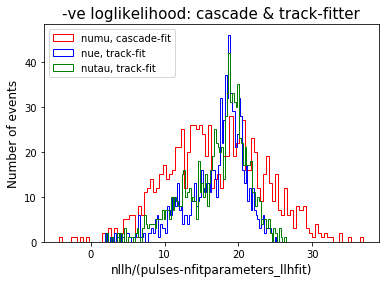

In [11]:
plt.hist(nloglike_cascade_numu, bins=100, histtype='step',label='numu, cascade-fit',color='red')
plt.hist(nloglike_track_nue, bins=100, histtype='step',label='nue, track-fit',color='blue')
plt.hist(nloglike_track_nutau, bins=100, histtype='step',label='nutau, track-fit',color='green')

plt.xlabel('nllh/(pulses-nfitparameters_llhfit)',fontsize=12)
plt.ylabel('Number of events',fontsize=12)
plt.title("-ve loglikelihood: cascade & track-fitter",fontsize=15)
plt.legend(loc='upper left')
plt.show()

In [15]:
print("nloglike_cascade_numu:",nloglike_cascade_numu)
print("-----------------------------------------------------------------")
print("nloglike_track_nue",nloglike_track_nue)
print("-----------------------------------------------------------------")
print("nloglike_track_nutau",nloglike_track_nutau)

nloglike_cascade_numu: [18.53101621792514, 20.396936193266345, 25.02904393083939, 15.27254763956457, 12.346383162602523, 20.08713255978405, 22.11902869136987, 23.64127031962764, -4.33074394182251, 13.978185792431322, 22.87836650238713, 13.159609115930063, 19.71574683708015, 11.957310551879734, 7.27542923337728, 20.466989765259434, 10.662470575791078, 22.009969114933646, 8.990556283763395, 20.281929963801847, 22.215562238247326, 22.40374129516405, 15.39841381536274, 20.224012809367718, 19.168470819587256, 25.200909803925438, 18.792615867182267, 19.968967777323204, 16.078624055967577, 12.557595014301862, 7.92244170392119, 16.779019164495402, 19.5200554698969, 30.393601337842934, 13.13884926586793, 3.381959319404376, 10.293266326456509, 23.077798079118267, 8.25882276028765, 10.985005302932764, 18.401038549780566, 28.658700634732618, 13.723435854869985, 18.63948904879878, 11.682687187224793, 16.94299682719485, 7.438648671275036, 24.62594164489637, 14.10226244121232, 19.232494093248533, 10.

In [79]:
print("nllh for nloglike_cascade_numu:",np.histogram(nloglike_cascade_numu,bins=100)[1][np.where(np.histogram(nloglike_cascade_numu,bins=100)[0]==np.max(np.histogram(nloglike_cascade_numu,bins=100)[0]))[0][0]])
print("nllh for nloglike_track_nue:",np.histogram(nloglike_track_nue,bins=100)[1][np.where(np.histogram(nloglike_track_nue,bins=100)[0]==np.max(np.histogram(nloglike_track_nue,bins=100)[0]))[0][0]])
print("nllh for nloglike_track_nutau:",np.histogram(nloglike_track_nutau,bins=100)[1][np.where(np.histogram(nloglike_track_nutau,bins=100)[0]==np.max(np.histogram(nloglike_track_nutau,bins=100)[0]))[0][0]])

nllh for nloglike_cascade_numu: 18.79978055983458
nllh for nloglike_track_nue: 18.656486415939934
nllh for nloglike_track_nutau: 18.64956926466238


### For NuMu events:

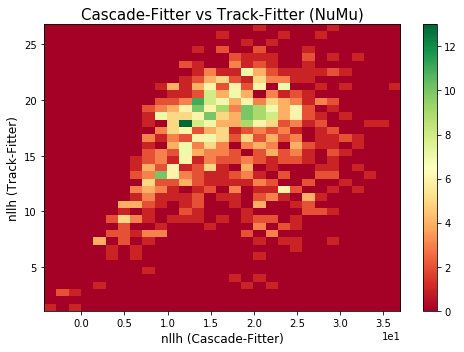

In [22]:
x_min = np.min(nloglike_cascade_numu)
x_max = np.max(nloglike_cascade_numu)
y_min = np.min(nloglike_track_numu)
y_max = np.max(nloglike_track_numu)
x_bins = np.linspace(x_min, x_max, 30)
y_bins = np.linspace(y_min, y_max, 40)

fig, ax = plt.subplots(figsize =(7, 5))
plt.hist2d(nloglike_cascade_numu, nloglike_track_numu, bins =[x_bins, y_bins], cmap='RdYlGn')
plt.title("Cascade-Fitter vs Track-Fitter (NuMu)",fontsize=15)
ax.set_ylabel('nllh (Track-Fitter)',fontsize=12) 
ax.set_xlabel('nllh (Cascade-Fitter)',fontsize=12) 

plt.colorbar()
plt.tight_layout() 
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

### For NuE events:

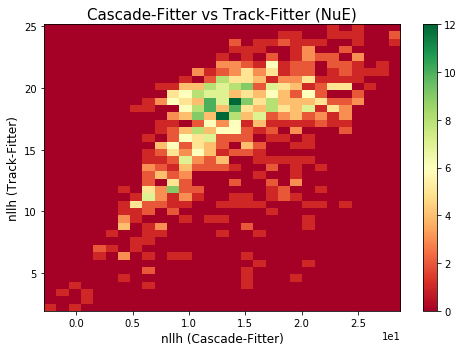

In [23]:
x_min = np.min(nloglike_cascade_nue)
x_max = np.max(nloglike_cascade_nue)
y_min = np.min(nloglike_track_nue)
y_max = np.max(nloglike_track_nue)
x_bins = np.linspace(x_min, x_max, 30)
y_bins = np.linspace(y_min, y_max, 40)

fig, ax = plt.subplots(figsize =(7, 5))
plt.hist2d(nloglike_cascade_nue, nloglike_track_nue, bins =[x_bins, y_bins], cmap='RdYlGn')
plt.title("Cascade-Fitter vs Track-Fitter (NuE)",fontsize=15)
ax.set_ylabel('nllh (Track-Fitter)',fontsize=12) 
ax.set_xlabel('nllh (Cascade-Fitter)',fontsize=12) 

plt.colorbar()
plt.tight_layout() 
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

### For NuTau events:

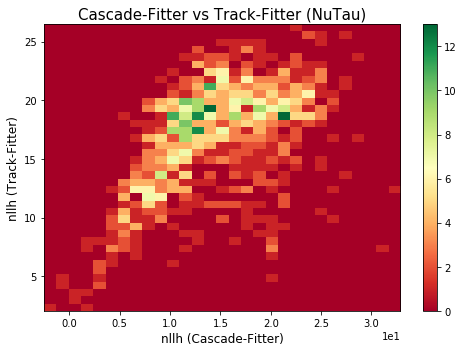

In [26]:
x_min = np.min(nloglike_cascade_nutau)
x_max = np.max(nloglike_cascade_nutau)
y_min = np.min(nloglike_track_nutau)
y_max = np.max(nloglike_track_nutau)
x_bins = np.linspace(x_min, x_max, 30)
y_bins = np.linspace(y_min, y_max, 40)

fig, ax = plt.subplots(figsize =(7, 5))
plt.hist2d(nloglike_cascade_nutau, nloglike_track_nutau, bins =[x_bins, y_bins], cmap='RdYlGn')
plt.title("Cascade-Fitter vs Track-Fitter (NuTau)",fontsize=15)
ax.set_ylabel('nllh (Track-Fitter)',fontsize=12) 
ax.set_xlabel('nllh (Cascade-Fitter)',fontsize=12) 

plt.colorbar()
plt.tight_layout() 
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()